## Import Libraries

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import keras_tuner as kt

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from scipy.spatial.distance import cosine

from PIL import Image, ImageEnhance

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


## Load Data

In [2]:
data = np.load("/kaggle/input/datasetmars1/mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


## Inspect Data
Plot some random samples from the dataset

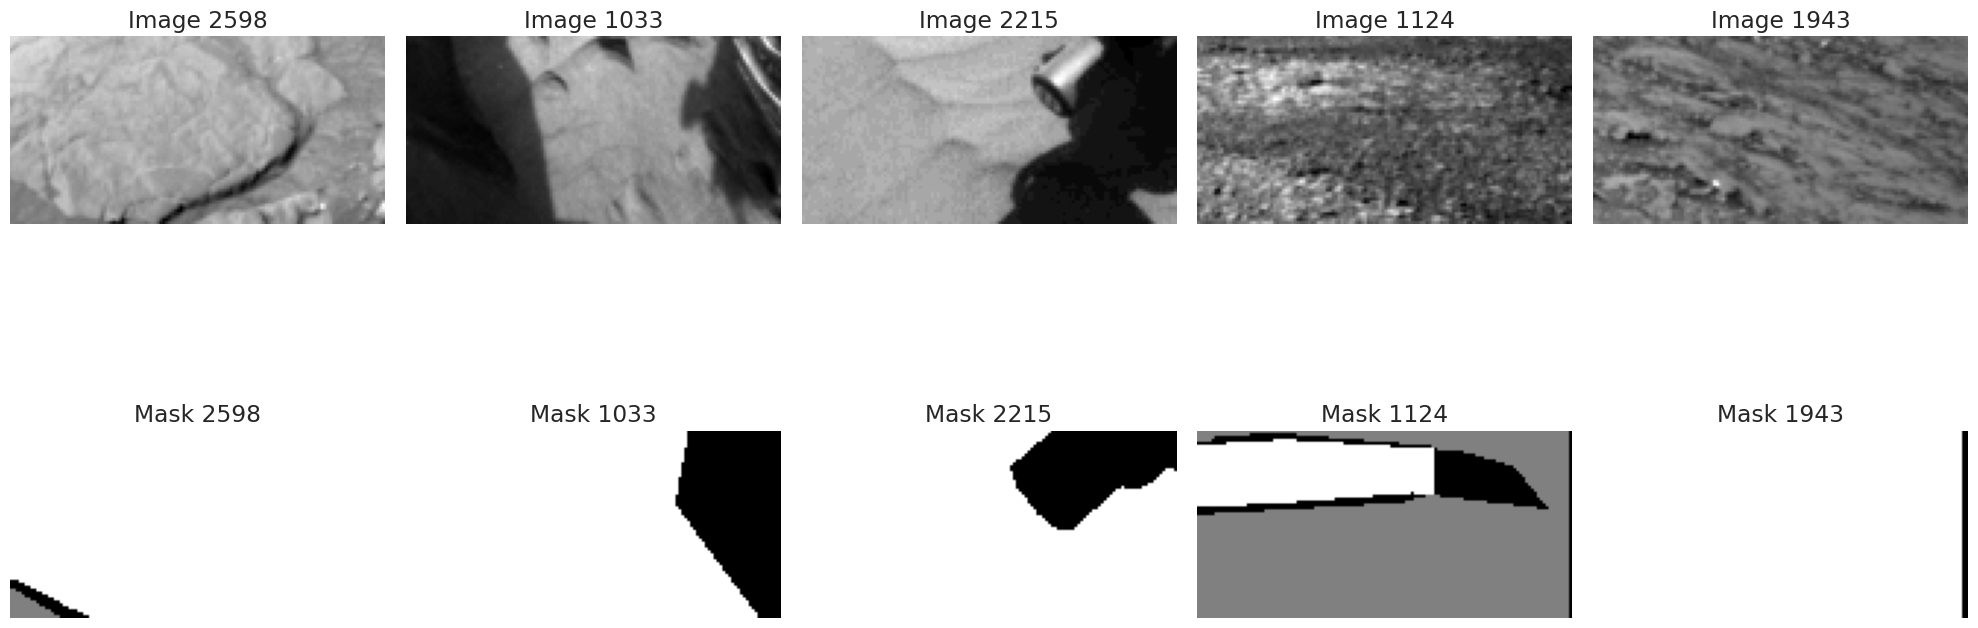

In [3]:
# Plot the randomly selected images
num_samples = 5
random_indices = np.random.choice(len(X_train), num_samples, replace=False)

fig, axes = plt.subplots(2, num_samples, figsize=(20, 10))

for i, index in enumerate(random_indices):
    # Mostra immagine originale
    ax_img = axes[0, i]
    ax_img.imshow(X_train[index], cmap='gray')  # Mostra l'immagine in scala di grigi
    ax_img.axis('off')  # Nascondi assi
    ax_img.set_title(f"Image {index}")

    # Mostra maschera corrispondente
    ax_mask = axes[1, i]
    ax_mask.imshow(y_train[index], cmap='gray')  # Mostra la maschera in scala di grigi
    ax_mask.axis('off')  # Nascondi assi
    ax_mask.set_title(f"Mask {index}")

plt.tight_layout()
plt.show()

### Manual selection of noise images


In [4]:
noise_indices = [62, 79, 125, 139, 142, 147, 152, 156, 170, 210, 217, 266, 289, 299, 313, 339, 348, 365, 412, 417, 426, 450, 461, \
                536, 552, 669, 675, 741, 744, 799, 802, 808, 820, 821, 849, 863, 890, 909, 942, 971, \
                1005, 1057, 1079, 1082, 1092, 1095, 1106, 1119, 1125, 1177, 1194, 1224, 1247, 1248, 1258, 1261, 1262, 1306, 1324, 1365, 1370, \
                1443, 1449, 1508, 1509, 1519, 1551, 1584, 1588, 1628, 1637, 1693, 1736, 1767, 1768, 1782, 1813, 1816, 1834, \
                1889, 1925, 1942, 1975, 1979, 2000, 2002, 2086, 2096, 2110, 2111, 2151, 2161, 2222, 2235, 2239, 2242, 2301, 2307, 2350, 2361, \
                2365, 2372, 2414, 2453, 2522, 2535]

print(f"Found {len(noise_indices)} contamination images")

Found 106 contamination images


### Split data into cleaned data and noise

In [5]:
def split_data(X, y, noise_indices):
    # Convert noise_indices to a set for faster lookup
    noise_indices_set = set(noise_indices)

    # Split into cleaned and contamination based on noise_indices
    contamination_X = X[noise_indices]
    contamination_y = y[noise_indices]
    
    # Get all indices that are not in noise_indices (cleaned data)
    cleaned_indices = [i for i in range(len(X)) if i not in noise_indices_set]

    # Cleaned data
    cleaned_X = X[cleaned_indices]
    cleaned_y = y[cleaned_indices]

    return cleaned_X, cleaned_y, contamination_X, contamination_y

cleaned_X, cleaned_y, contamination_X, contamination_y = split_data(X_train, y_train, noise_indices)

# To check the results
print(f"Cleaned data shape: {cleaned_X.shape}")
print(f"Contamination data shape: {contamination_X.shape}")


Cleaned data shape: (2509, 64, 128)
Contamination data shape: (106, 64, 128)


### Inspect a slice of cleaned data

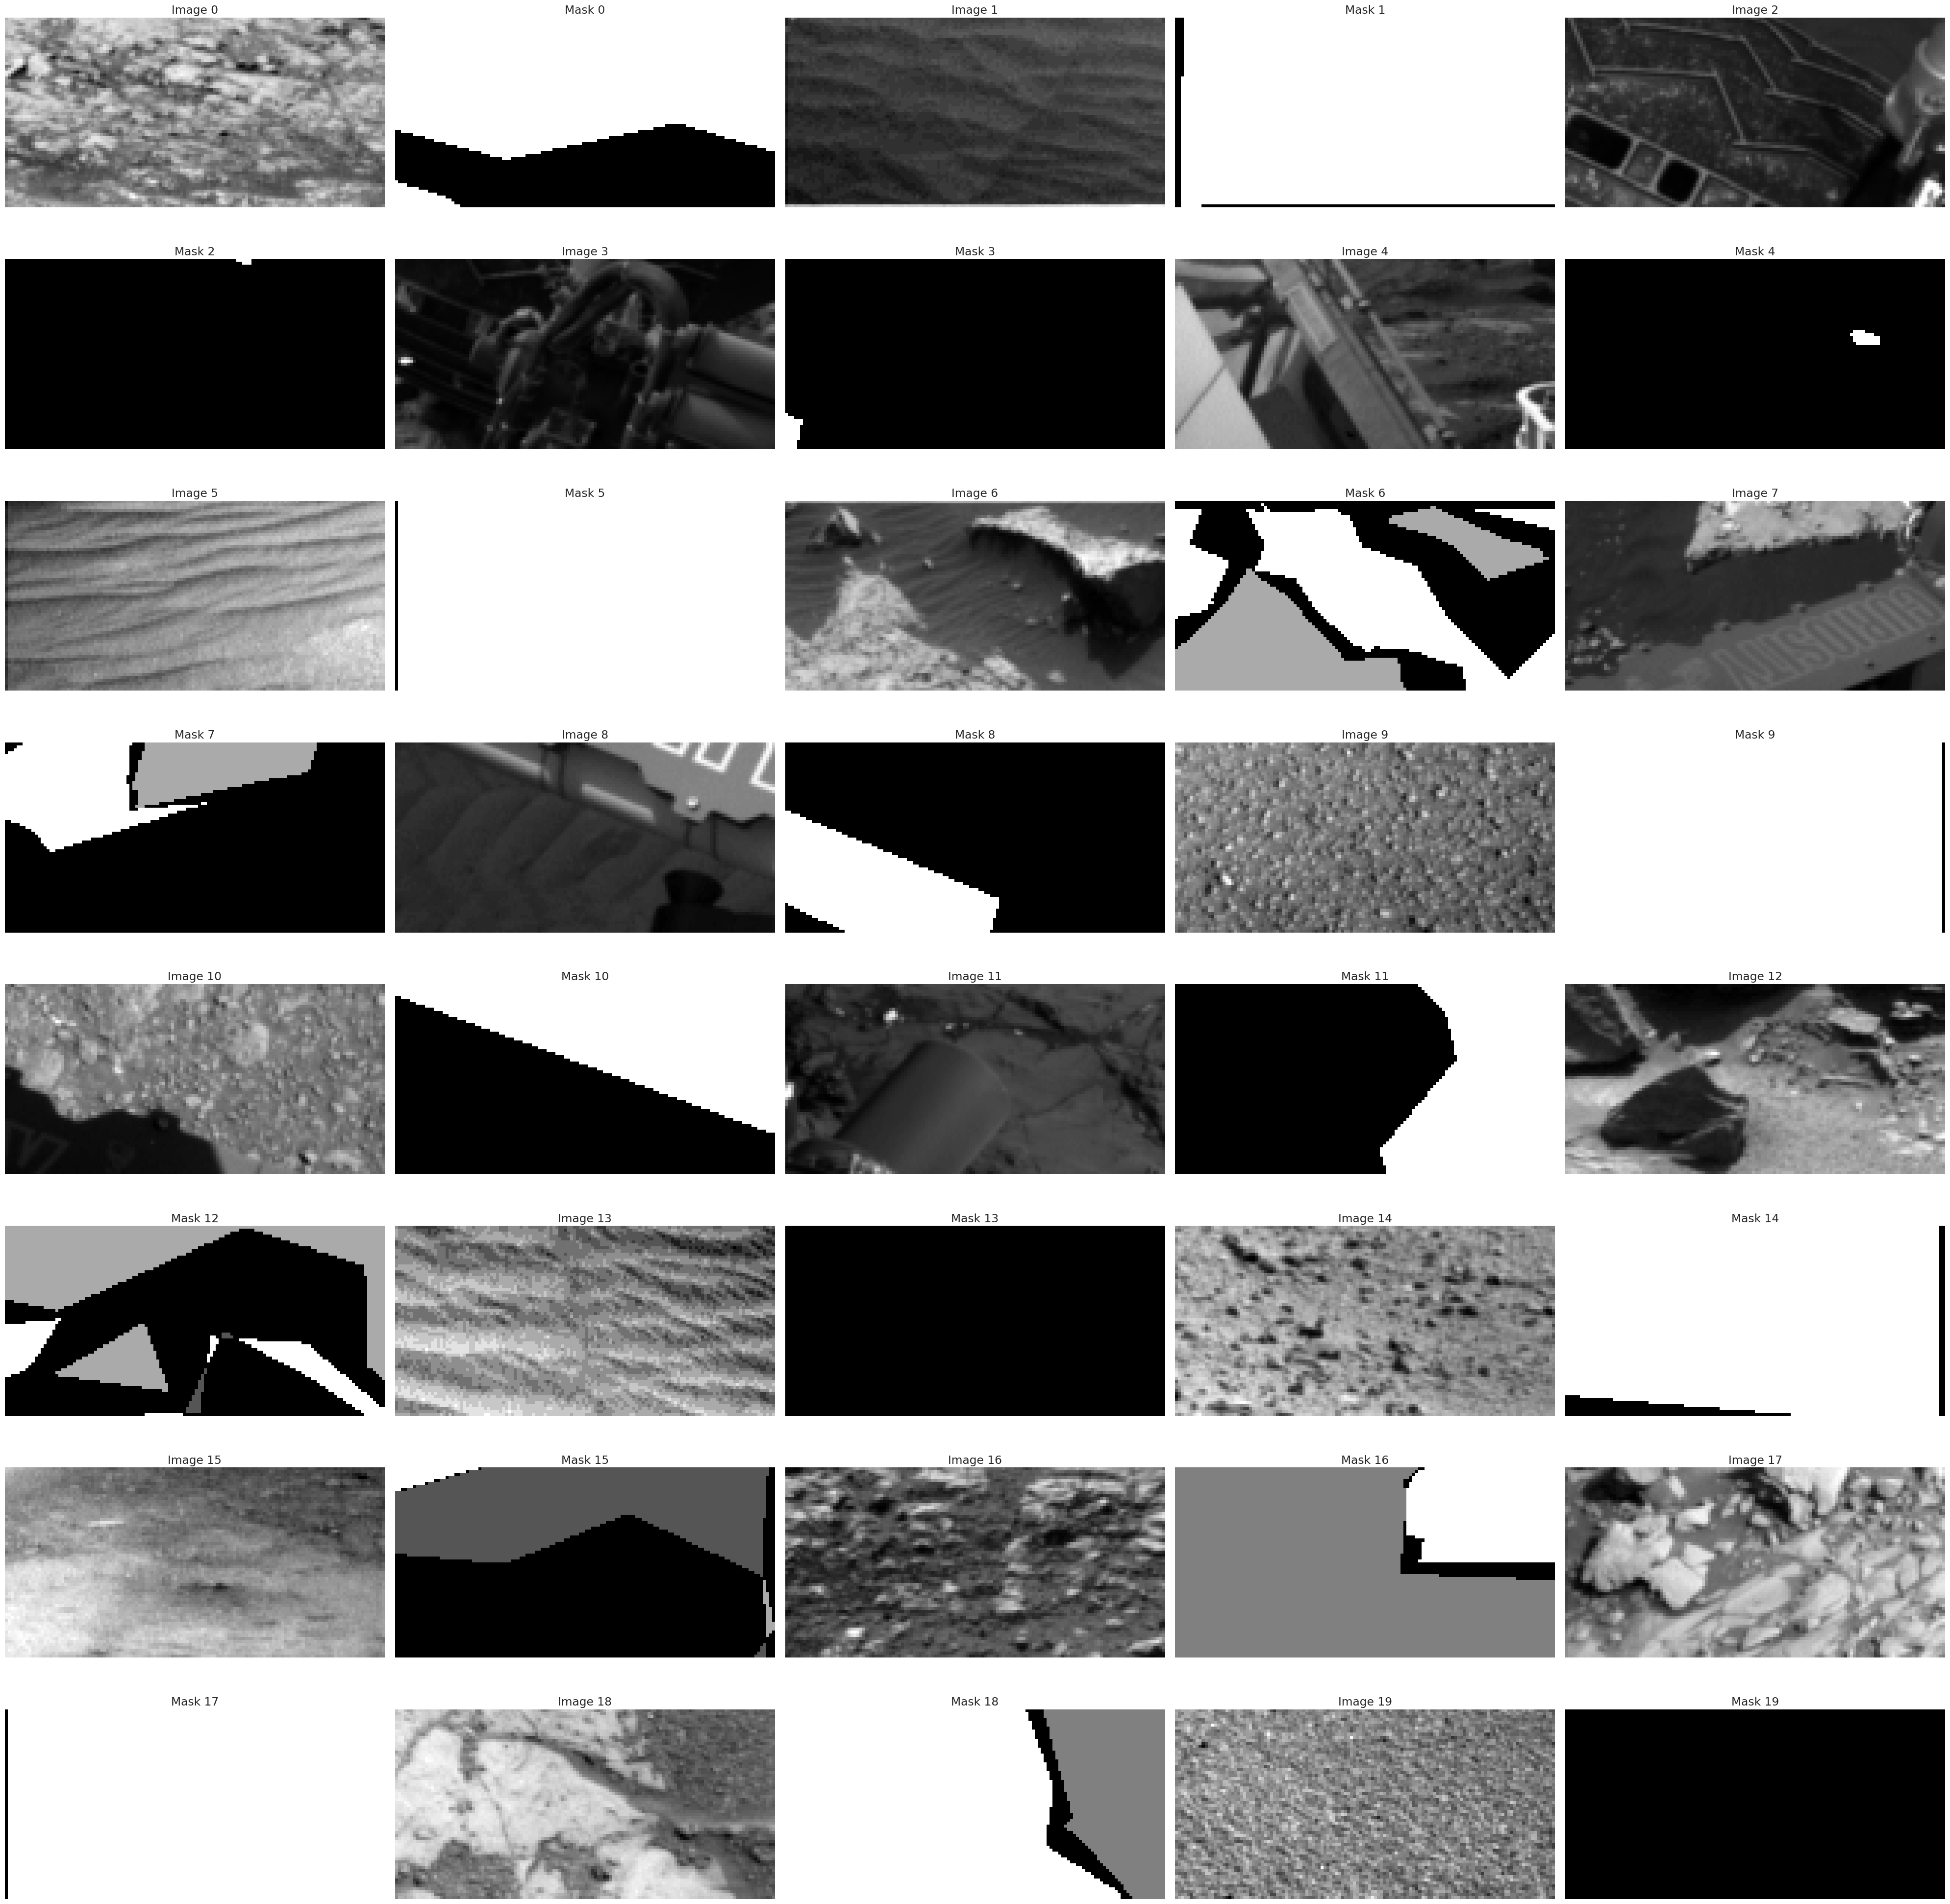

In [6]:
# Parameters for layout
X_train_cleaned_selected = cleaned_X[:20]
masks_cleaned_selected = cleaned_y[:20]  # Selezione delle maschere corrispondenti
images_per_row = 5  # Numero di immagini per riga

num_images = len(X_train_cleaned_selected)  # Numero totale di immagini
num_rows = math.ceil(2 * num_images / images_per_row)  # Calcolo delle righe (2 righe per immagine e maschera)

# Create subplots
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(40, 5 * num_rows))

# Flatten the axes for easier iteration
axes = axes.ravel()

# Plot images and their corresponding masks
for i, ax in enumerate(axes):
    if i < 2 * num_images:
        if i % 2 == 0:  # Immagini originali
            img_index = i // 2
            ax.imshow(X_train_cleaned_selected[img_index], cmap='gray')  # Mostra immagine
            ax.axis('off')  # Nasconde gli assi
            ax.set_title(f"Image {img_index}")
        else:  # Maschere corrispondenti
            mask_index = i // 2
            ax.imshow(masks_cleaned_selected[mask_index], cmap='gray')  # Mostra maschera
            ax.axis('off')  # Nasconde gli assi
            ax.set_title(f"Mask {mask_index}")
    else:
        ax.axis('off')  # Nasconde eventuali assi inutilizzati
plt.tight_layout()
plt.show()

### Inspect all of the noise images

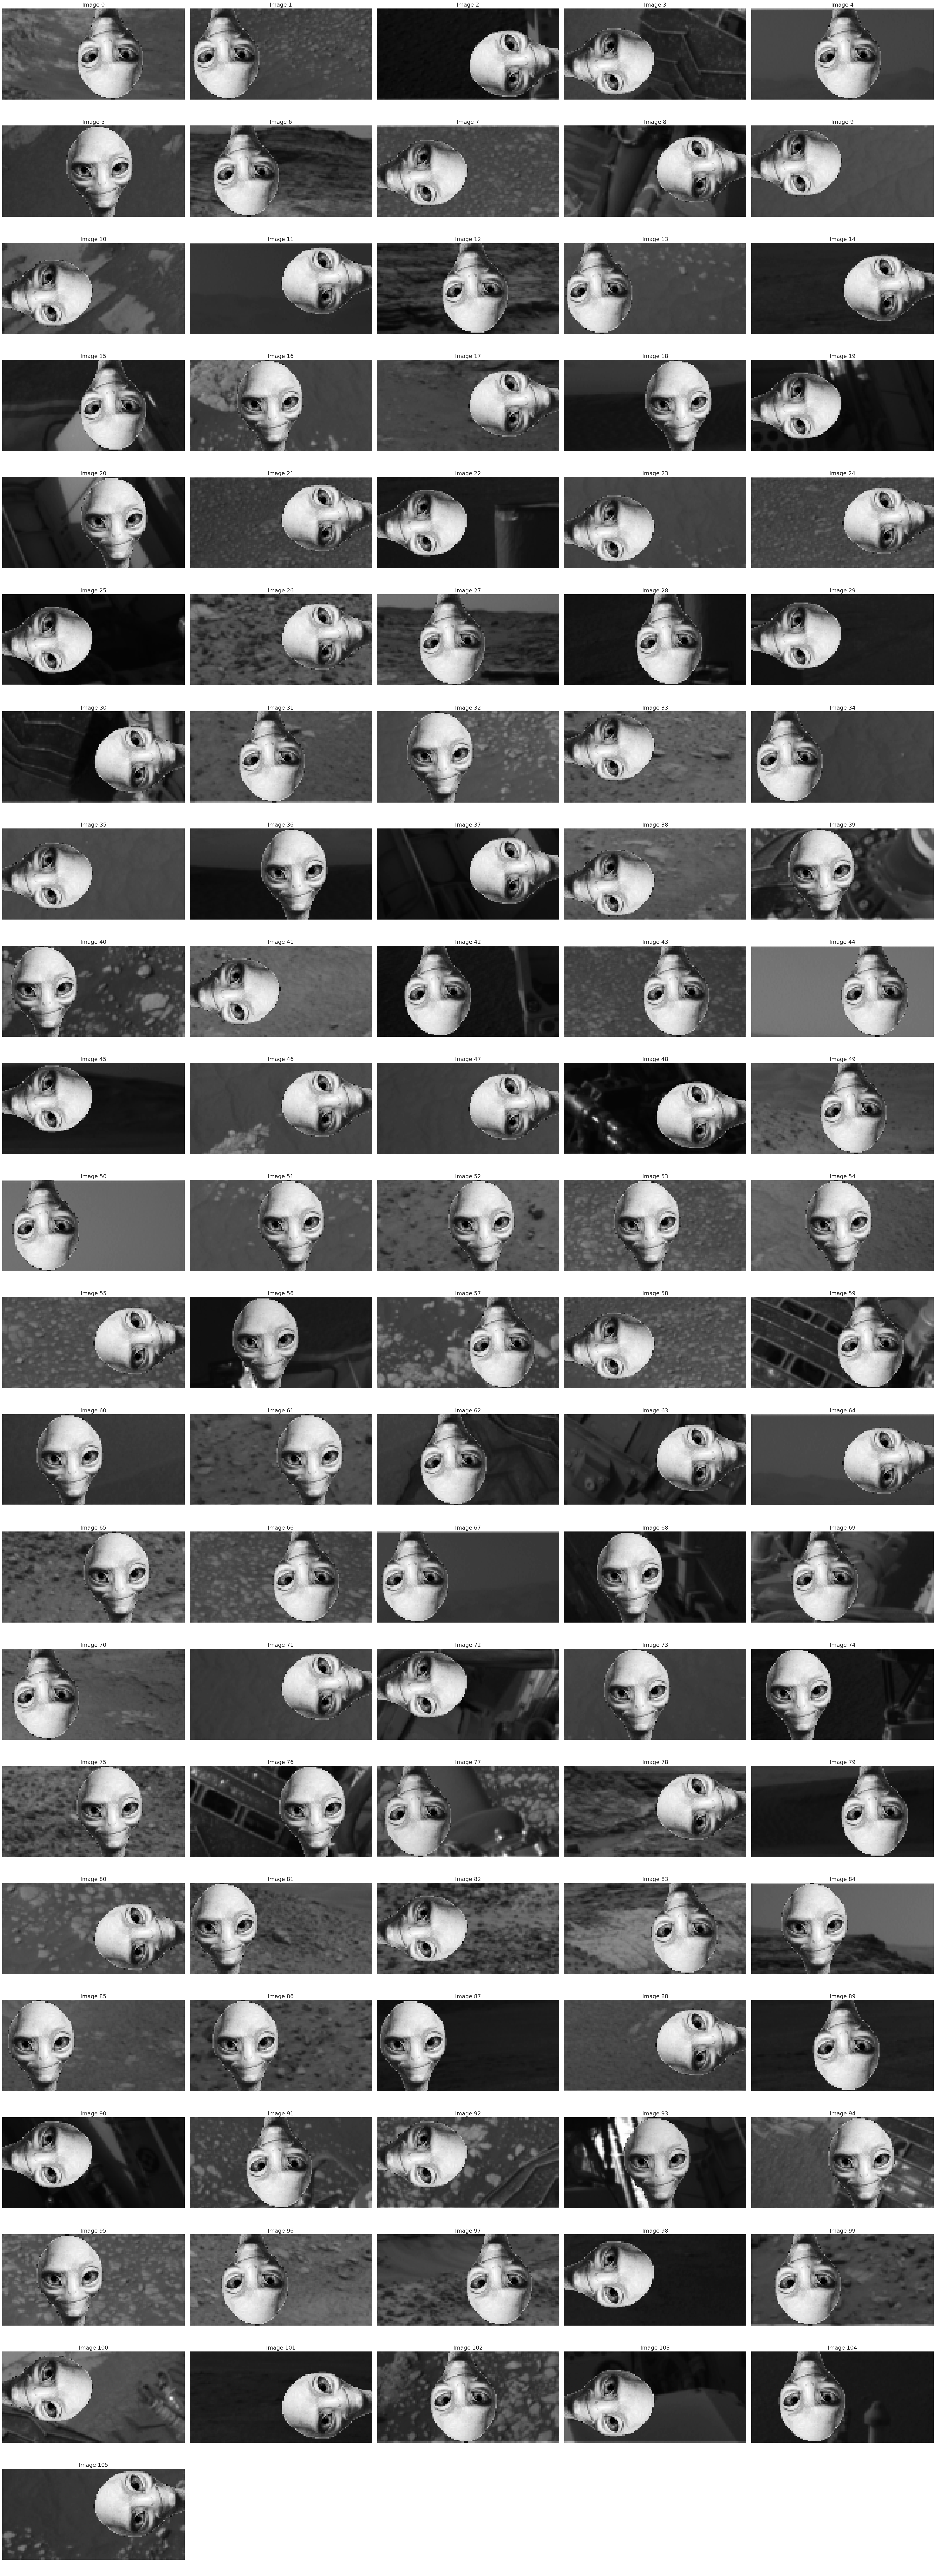

In [7]:
# Parameters for layout
images_per_row = 5  # Number of images per row
num_images = len(contamination_X)  # Total number of images
num_rows = math.ceil(num_images / images_per_row)  # Calculate the number of rows

# Create subplots
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(40, 5 * num_rows))

# Flatten the axes for easier iteration (handles cases where `axes` is 2D)
axes = axes.ravel()

# Plot all the contamination images
for i, ax in enumerate(axes):
    if i < num_images:
        ax.imshow(contamination_X[i], cmap='gray')  # Display the image in grayscale
        ax.axis('off')  # Hide axis
        ax.set_title(f"Image {i}")
    else:
        ax.axis('off')  # Hide any unused subplot axes

plt.tight_layout()
plt.show()

### Looking at cleaned data

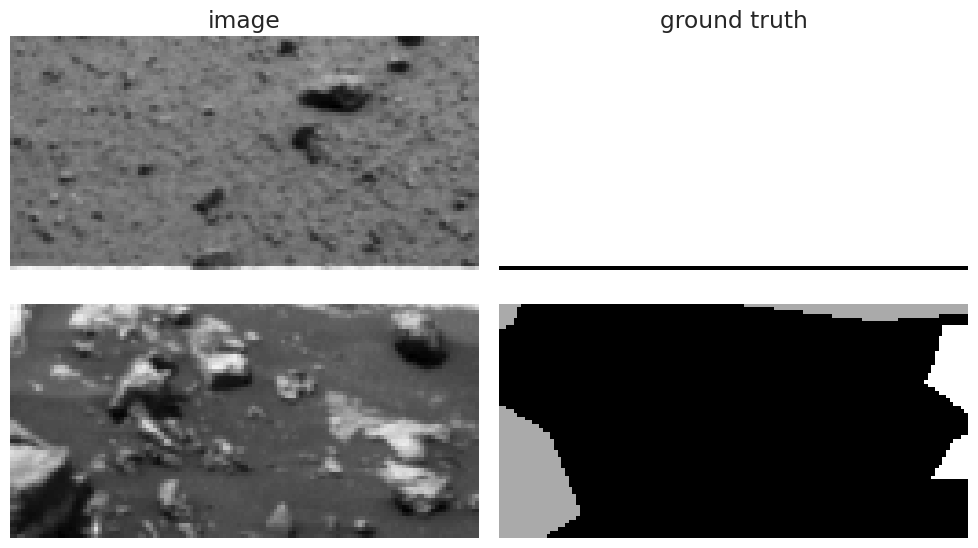

In [8]:
plt.figure(figsize=(10, 6))

random_index1 = 1300
random_index2 = 1100

# Plot first image
plt.subplot(2, 2, 1)
plt.imshow(cleaned_X[random_index1], cmap="gray")
plt.axis("off")
plt.title("image")
plt.subplot(2, 2, 2)
plt.imshow(cleaned_y[random_index1], cmap="gray")
plt.title("ground truth")
plt.axis("off")

# Plot second image
plt.subplot(2, 2, 3)
plt.imshow(cleaned_X[random_index2], cmap="gray")
plt.axis("off")
plt.subplot(2, 2, 4)
plt.imshow(cleaned_y[random_index2], cmap="gray")
plt.axis("off")

# Display the images
plt.tight_layout()
plt.show()

In [9]:
category_map = {
        0: 0,  # background
        1: 1,  # soil
        2: 2,  # bedrock
        3: 3,  # sand
        4: 4,  # big rock
}

# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 200

# Set data split size for training and validation
SPLITS_SIZE = 300

NUM_CLASSES = len(set(category_map.values()))
print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 5


### Split into training and validation

In [10]:
# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(
    cleaned_X, cleaned_y, test_size=0.2, random_state=42
)

# Print the shapes to confirm the split
print(f"Training set: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Validation set: X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


Training set: X_train shape: (2007, 64, 128), y_train shape: (2007, 64, 128)
Validation set: X_val shape: (502, 64, 128), y_val shape: (502, 64, 128)


In [11]:
# Normalize the data to [0, 1]
X_train = X_train / 255.0
X_val = X_val / 255.0

# Check if the data already has the channel dimension (i.e., check if the shape has 4 dimensions)
if X_train.ndim == 3:  # (batch_size, height, width)
    # Add the channel dimension if missing
    X_train = np.expand_dims(X_train, axis=-1)  # Adds the channel dimension
    X_val = np.expand_dims(X_val, axis=-1)  # Same for validation data

# Check the shapes to make sure they are correct
print(f"X_train shape: {X_train.shape}")  # Should be (batch_size, 64, 128, 1)
print(f"X_val shape: {X_val.shape}")  # Same for validation


X_train shape: (2007, 64, 128, 1)
X_val shape: (502, 64, 128, 1)


In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)

# Check the shape of the dataset to ensure it's batched correctly
for images, labels in train_dataset.take(1):
    print(f"Batch shape: {images.shape}")  # Should be (batch_size, 64, 128, 1)


Batch shape: (32, 64, 128, 1)


## Models

In [13]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    
    x = tfkl.Conv2D(filters, (kernel_size, kernel_size), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = tfkl.Dropout(0.2)(x)
    x = tfkl.Conv2D(filters, (kernel_size, kernel_size), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    #x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same')(x)
    #x = tfkl.BatchNormalization()(x)
    #x = tfkl.Activation(activation)(x)
    # Return the transformed tensor
    return x

In [16]:
def load_single_image(image_path, label_path, input_size=(64, 128)):
    """
    Load a single image-label pair with the correct shape.
    """
    # Read and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=1)  # Ensure 3 channels
    image = tf.image.resize(image, input_size)   # Resize to fixed size
    image = tf.cast(image, tf.float32) / 255.0

    # Read and preprocess the label
    label = tf.io.read_file(label_path)
    label = tf.io.decode_png(label, channels=1)  # Ensure single channel
    label = tf.image.resize(label, input_size, method='bilinear')  # Resize to fixed size
    label = tf.cast(label, tf.int32)

    return image, label

In [17]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_dataset, frequency=10):
        # Pass the full validation dataset and frequency for visualization
        self.val_dataset = val_dataset
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            # Get one batch from the validation dataset
            for image_batch, label_batch in self.val_dataset.take(1):
                # Choose the first image in the batch for visualization
                image = image_batch[0].numpy()
                label = label_batch[0].numpy()

                # Add the batch dimension to image (model expects a batch of images)
                image = np.expand_dims(image, axis=0)  # Shape (1, 64, 128, 1)

                pred = self.model.predict(image, verbose=0)
                y_pred = tf.math.argmax(pred, axis=-1)
                y_pred = y_pred.numpy()

                # Create colormap
                num_classes = NUM_CLASSES
                # colormap = create_segmentation_colormap(num_classes)

                plt.figure(figsize=(16, 4))

                # Input image
                plt.subplot(1, 3, 1)
                plt.imshow(image.squeeze())
                plt.title("Input Image")
                plt.axis('off')
    
                # Ground truth
                plt.subplot(1, 3, 2)
                # colored_label = apply_colormap(label.squeeze(), colormap)
                plt.imshow(label.squeeze())
                plt.title("Ground Truth Mask")
                plt.axis('off')
    
                # Prediction
                plt.subplot(1, 3, 3)
                # colored_pred = apply_colormap(y_pred.squeeze(), colormap)
                plt.imshow(y_pred.squeeze())
                plt.title("Predicted Mask")
                plt.axis('off')
    
                plt.tight_layout()
                plt.show()
                plt.close()

                # Visualize the image and label
                # plt.figure(figsize=(10, 5))
                # plt.subplot(1, 2, 1)
                # plt.imshow(image.squeeze(), cmap="gray")
                # plt.title("Image")
                # plt.axis('off')

                # plt.subplot(1, 2, 2)
                # plt.imshow(label.squeeze(), cmap="gray")
                # plt.title("Label")
                # plt.axis('off')

                plt.show()


In [19]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

# viz_callback = VizCallback(X_val[0], y_val[0])
viz_callback = VizCallback(val_dataset, frequency=10)


In [21]:
# Function for the hyperparameter U-Net model
def build_unet_model(hp,input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    
    input_layer = tfkl.Input(shape=(64, 128, 1), name='input_layer')  

    # Hyperparameters tuning
    num_filters = hp.Choice("num_filters", values=[ 8 , 16], default=16)
    activation = hp.Choice("activation", values=["leaky_relu"], default="leaky_relu")
    kernel_size = hp.Choice("kernel_size", values=[3], default=3)
    num_levels = hp.Int("num_levels", min_value=2, max_value=5, step=1, default=4)  # Numero di livelli encoder/decoder

    # Encoder
    x = input_layer
    skips = []
    for _ in range(num_levels):
        x = unet_block(input_tensor = x,filters = num_filters, kernel_size = kernel_size, activation = activation)
        skips.append(x)
        x = tfkl.MaxPooling2D((2,2))(x)
        num_filters *= 2

    # Bottleneck
    x = unet_block(input_tensor = x,filters = num_filters, kernel_size = kernel_size, activation = activation)

    # Decoder
    for skip in reversed(skips):
        num_filters //= 2
        x = tfkl.Conv2DTranspose(num_filters, kernel_size = kernel_size, strides=2, padding="same")(x)
        x = tfkl.concatenate([x, skip])
        x = unet_block(input_tensor = x,filters = num_filters, kernel_size = kernel_size, activation = activation)

    # Output layer 
    output_layer = tfkl.Conv2D(num_classes, kernel_size = 1 , padding = 'same', activation="softmax")(x)

    # Costruisci il modello
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # Per segmentazione multiclasse
        metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
    )

    # Print a detailed summary of the model with expanded nested layers and trainable parameters.
    model.summary(expand_nested=True, show_trainable=True)

    # Generate and display a graphical representation of the model architecture.
    tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

    return model



In [22]:

# Use Keras Tuner for findings best iperparameters
def hyperparameter_tuning(train, val):
    tuner = kt.Hyperband(
        build_unet_model,
        objective=kt.Objective("val_mean_iou", direction="max"),
        max_epochs=20,
        factor=5,
        directory="hyperparameter_tuning_multiclass",
        project_name="multiclass_segmentation_with_levels"
    )

    # Callbacks
        # Setup callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=PATIENCE,
        restore_best_weights=True
    )

    # Start the tuning
    tuner.search(
        train,
        validation_data=val,
        callbacks=[early_stopping]
    )

    # Get the best value found by the hyperparameter tuning model
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"""
    Best hyperparameters:
    - Number of filters: {best_hps.get("num_filters")}
    - Activation function: {best_hps.get("activation")}
    - Kernel size: {best_hps.get("kernel_size")}
    - Number of levels: {best_hps.get("num_levels")}
    """)

    return tuner

In [23]:
# Add ReduceLROnPlateau for fine-tuning
def train_final_model(train, val, tuner):
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    model = tuner.hypermodel.build(best_hps)

    # Callback for ReduceLROnPlateau
    reduce_lr = tfk.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1
    )

    # Fit the model
    history = model.fit(
        train,
        validation_data=val,
        epochs=EPOCHS,
        verbose=1,
        callbacks=[
            early_stopping, 
            viz_callback,
            reduce_lr
        ]
    )

    return model, history

In [24]:
# Execute tuning and fitting
tuner = hyperparameter_tuning(train_dataset, val_dataset)

Trial 7 Complete [00h 00m 46s]
val_mean_iou: 0.08357889205217361

Best val_mean_iou So Far: 0.17011389136314392
Total elapsed time: 00h 06m 14s

    Best hyperparameters:
    - Number of filters: 16
    - Activation function: leaky_relu
    - Kernel size: 3
    - Number of levels: 5
    


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_15         │ (None, 64, 128, │       160 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 16)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout_7         │ (None, 64, 128, │         0 │ conv2d_15[0][… │   -   │
│ (Dropout)         │ 16)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_16         │ (None, 64, 128, │     2,320 │ dropout_7[0][… │   Y   │
│ (Conv2D)          │ 16)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_3   │ (None, 32, 64,  │         0 │ conv2d_16[0][… │   -   │
│ (MaxPooling2D)    │ 16)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_17         │ (None, 32, 64,  │     4,640 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout_8         │ (None, 32, 64,  │         0 │ conv2d_17[0][… │   -   │
│ (Dropout)         │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_18         │ (None, 32, 64,  │     9,248 │ dropout_8[0][… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_4   │ (None, 16, 32,  │         0 │ conv2d_18[0][… │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_19         │ (None, 16, 32,  │    18,496 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout_9         │ (None, 16, 32,  │         0 │ conv2d_19[0][… │   -   │
│ (Dropout)         │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_20         │ (None, 16, 32,  │    36,928 │ dropout_9[0][… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_5   │ (None, 8, 16,   │         0 │ conv2d_20[0][… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_21         │ (None, 8, 16,   │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout_10        │ (None, 8, 16,   │         0 │ conv2d_21[0][… │   -   │
│ (Dropout)         │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_22         │ (None, 8, 16,   │   147,584 │ dropout_10[0]… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_6   │ (None, 4, 8,    │         0 │ conv2d_22[0][… │   - 

 Total params: 8,648,341 (32.99 MB)

 Trainable params: 8,648,341 (32.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.3056 - loss: 1.4632 - mean_iou: 0.1036

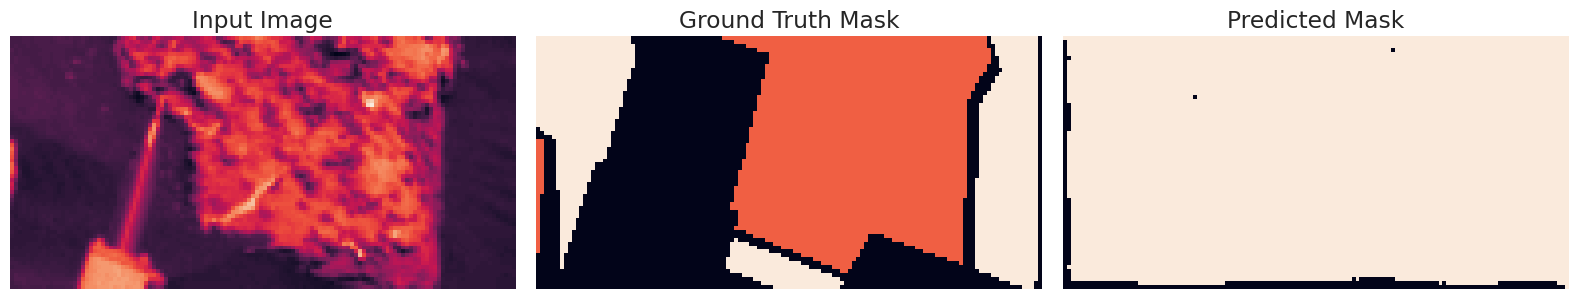

63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 505ms/step - accuracy: 0.3058 - loss: 1.4624 - mean_iou: 0.1036 - val_accuracy: 0.3425 - val_loss: 1.3806 - val_mean_iou: 0.0847 - learning_rate: 0.0010
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.3311 - loss: 1.3778 - mean_iou: 0.0991 - val_accuracy: 0.3361 - val_loss: 1.3624 - val_mean_iou: 0.0662 - learning_rate: 0.0010
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.3472 - loss: 1.3569 - mean_iou: 0.0922 - val_accuracy: 0.3382 - val_loss: 1.3558 - val_mean_iou: 0.0776 - learning_rate: 0.0010
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.3517 - loss: 1.3430 - mean_iou: 0.0976 - val_accuracy: 0.3760 - val_loss: 1.3144 - val_mean_iou: 0.1262 - learning_rate: 0.0010
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.3828 - loss: 1.2991 - mean_iou: 0.1448 - val_accuracy: 0.4083 - val_loss: 1.2994 - val_mean_iou: 0.1501 - learning_rate: 0.0010
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 3

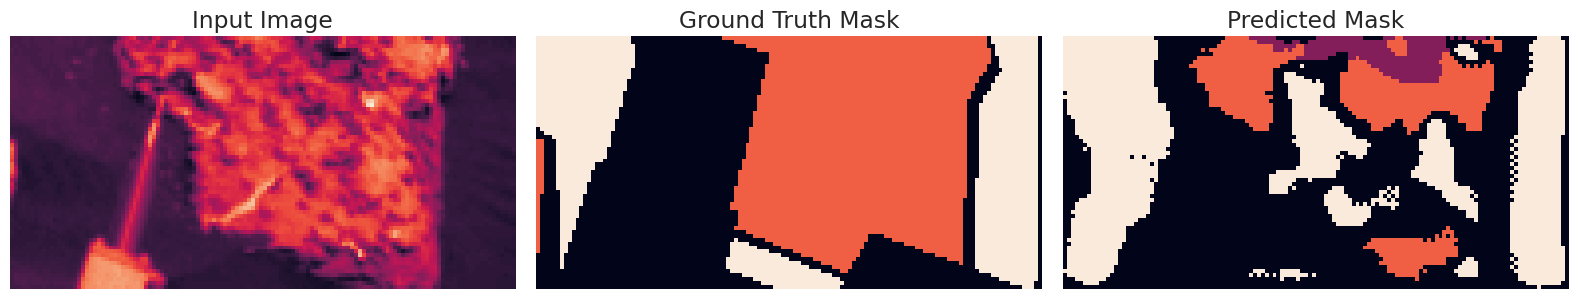

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.5649 - loss: 1.0331 - mean_iou: 0.2760 - val_accuracy: 0.4400 - val_loss: 1.5219 - val_mean_iou: 0.1781 - learning_rate: 2.5000e-04
Epoch 12/200
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5771 - loss: 1.0175 - mean_iou: 0.2870
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.5775 - loss: 1.0169 - mean_iou: 0.2871 - val_accuracy: 0.4471 - val_loss: 1.5249 - val_mean_iou: 0.1856 - learning_rate: 2.5000e-04
Epoch 13/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.5981 - loss: 0.9816 - mean_iou: 0.3041 - val_accuracy: 0.4431 - val_loss: 1.6752 - val_mean_iou: 0.1832 - learning_rate: 1.2500e-04
Epoch 14/200
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6069 - loss: 0.9665 - mean_iou: 0.3122
Epoch 14: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.6072 - los

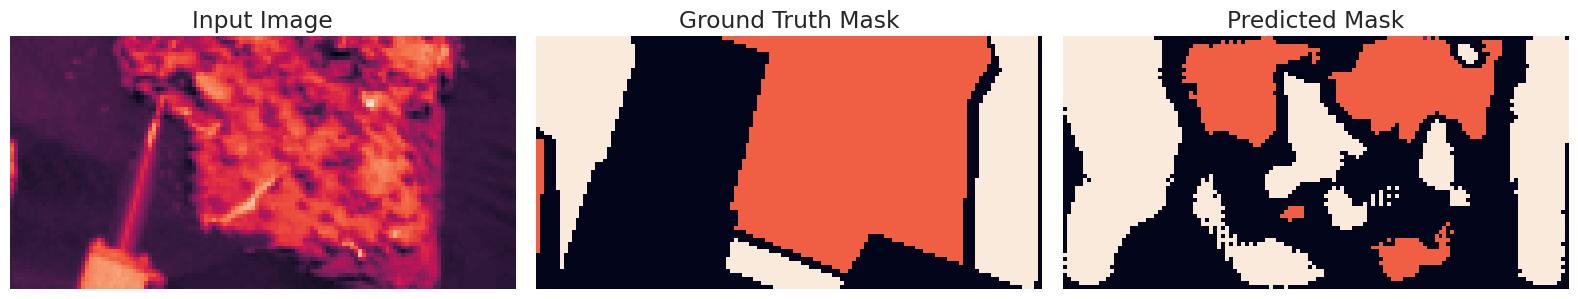

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.6487 - loss: 0.8937 - mean_iou: 0.3519 - val_accuracy: 0.4543 - val_loss: 1.8746 - val_mean_iou: 0.1980 - learning_rate: 7.8125e-06
Epoch 22/200
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6503 - loss: 0.8892 - mean_iou: 0.3549
Epoch 22: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.6505 - loss: 0.8889 - mean_iou: 0.3549 - val_accuracy: 0.4544 - val_loss: 1.8836 - val_mean_iou: 0.1988 - learning_rate: 7.8125e-06
Epoch 23/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.6520 - loss: 0.8872 - mean_iou: 0.3571 - val_accuracy: 0.4533 - val_loss: 1.8956 - val_mean_iou: 0.1975 - learning_rate: 3.9063e-06
Epoch 24/200
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6532 - loss: 0.8880 - mean_iou: 0.3587
Epoch 24: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6534 - l

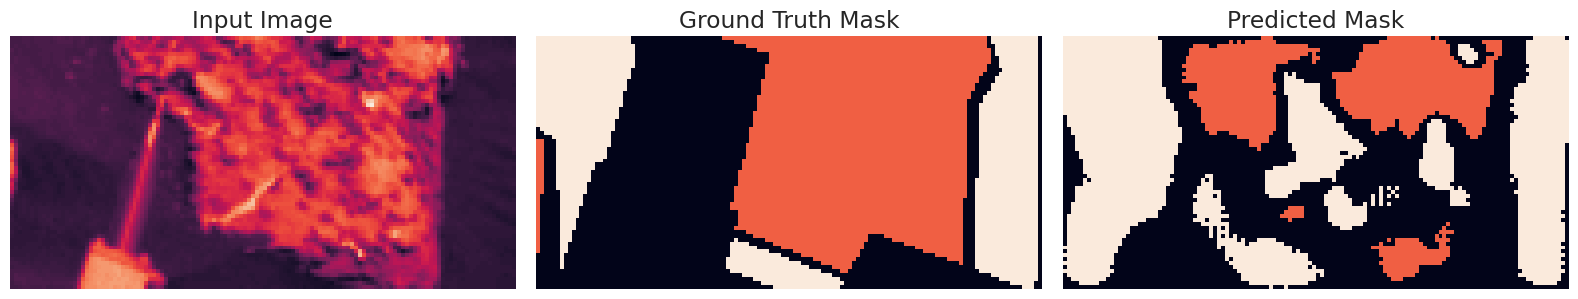

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.6543 - loss: 0.8872 - mean_iou: 0.3594 - val_accuracy: 0.4528 - val_loss: 1.9164 - val_mean_iou: 0.1970 - learning_rate: 1.0000e-06
Epoch 32/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6556 - loss: 0.8845 - mean_iou: 0.3605 - val_accuracy: 0.4526 - val_loss: 1.9193 - val_mean_iou: 0.1968 - learning_rate: 1.0000e-06
Epoch 33/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6552 - loss: 0.8828 - mean_iou: 0.3611 - val_accuracy: 0.4531 - val_loss: 1.9169 - val_mean_iou: 0.1973 - learning_rate: 1.0000e-06
Epoch 34/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6549 - loss: 0.8826 - mean_iou: 0.3605 - val_accuracy: 0.4528 - val_loss: 1.9196 - val_mean_iou: 0.1971 - learning_rate: 1.0000e-06
Epoch 35/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6573 - loss: 0.8797 - mean_iou: 0.3624 - val_accuracy: 0.4528 - val_loss: 1.9206 - val_mean_iou: 0.1970 - learning_rate: 1.0000e-06
Epoch 36/200
63/63

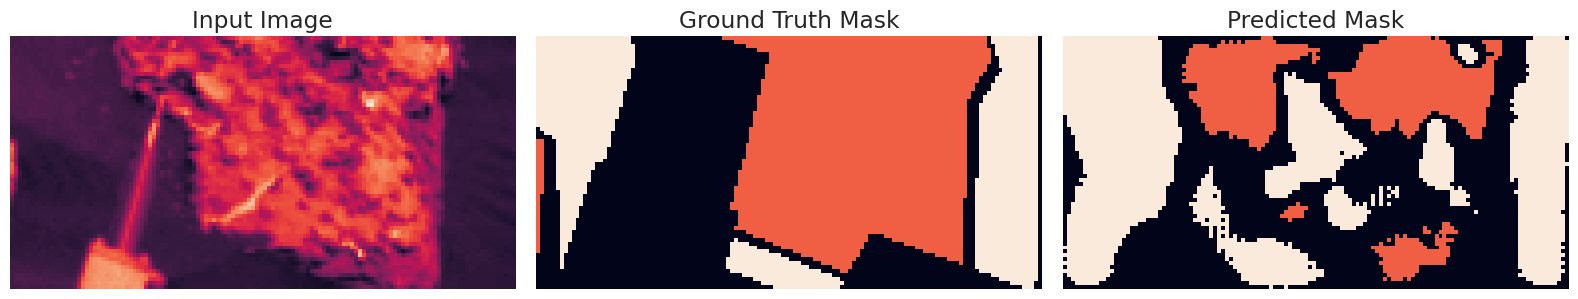

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.6547 - loss: 0.8843 - mean_iou: 0.3608 - val_accuracy: 0.4527 - val_loss: 1.9261 - val_mean_iou: 0.1971 - learning_rate: 1.0000e-06
Epoch 42/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.6573 - loss: 0.8786 - mean_iou: 0.3634 - val_accuracy: 0.4528 - val_loss: 1.9265 - val_mean_iou: 0.1973 - learning_rate: 1.0000e-06
Epoch 43/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.6564 - loss: 0.8806 - mean_iou: 0.3623 - val_accuracy: 0.4530 - val_loss: 1.9263 - val_mean_iou: 0.1976 - learning_rate: 1.0000e-06
Epoch 44/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.6597 - loss: 0.8760 - mean_iou: 0.3646 - val_accuracy: 0.4530 - val_loss: 1.9281 - val_mean_iou: 0.1974 - learning_rate: 1.0000e-06
Epoch 45/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.6547 - loss: 0.8845 - mean_iou: 0.3605 - val_accuracy: 0.4531 - val_loss: 1.9288 - val_mean_iou: 0.1976 - learning_rate: 1.0000e-06
Epoch 46/200
63/63

In [25]:
final_model, history = train_final_model(train_dataset, val_dataset, tuner)

In [26]:
# Calculate and print the final validation accuracy
#final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
#print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_70.keras'
final_model.save(model_filename)

# Delete the model to free up resources
del final_model

In [27]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('UNet_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [28]:
model_filename = 'UNet_70.keras'
model = tfk.models.load_model(model_filename, compile=False)
# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
print(f"Model loaded from {model_filename}")

Model loaded from UNet_70.keras


In [29]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step
Predictions shape: (10022, 64, 128)


In [30]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [31]:
# Create and download the csv submission file
timestep_str = model_filename.replace("UNet_", "").replace(".keras", "")
submission_filename = f"submission_70.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

# from google.colab import files
# files.download(submission_filename)